# [Qubit Lattice Model](https://doi.org/10.1117/12.485960)
> _Venegas-Andraca SE, Bose S (2003)_ "Storing, processing, and retrieving an image using quantum mechanics" In: Quantum information and computation, vol 5105, pp 137–147. https://doi.org/10.1117/12.485960. International society for optics and photonics.

A naive algorithm that consists of literally copying the classical representation in quantum. Therefore, the circuit width is $2^{2n}$ for $2^{n} \times 2^{n}$ grayscale image. 

In order to encode RGB images, a lattice of qubits can be used, where each 'layer' holds the intensities of one color. The authors propose using a $R_{y}$ rotation gate to encode the pixel intensity. While this is the first formulation of quantum image storing, it has a major drawback of having large circuit width. This approach does not use quantum features like entanglement and superposition, and hence it has considerably low circuit depth.

In [1]:
from qiskit import QuantumRegister, ClassicalRegister, AncillaRegister, QuantumCircuit
from qiskit.quantum_info import Statevector, Operator
from qiskit_aer import Aer 
from qiskit import transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector, plot_distribution, plot_state_qsphere
import matplotlib.pyplot as plt
import numpy as np
import math

In order to determine the angle of rotation based on the intensity, we use numpy's interpolation method. This will convert our input values from the range (0, 255) to (o, $\pi$).

Interpolation:
$$
y = y_{1} + (x - x_{1}) \frac{(y_{2} - y_{1})}{(x_{2} - x_{1})}
$$

where, $(x_{1}, y_{1}) = (0, 0)$, $(x_{2}, y_{2}) = (255, \pi)$

This will give us the angles $\in [o, \pi]$ for every input value between 0 and 255.


In [2]:
# INPUT
def getInput(verbose=False):
    input_vector = np.linspace(start=0, stop=255, num=4, dtype=int)
    if verbose:
        plt.title('Input image')
        plt.imshow(input_vector.reshape(2,2), cmap='gray')

    input_angles = np.interp(input_vector, (0, 255), (0, np.pi))
    if verbose: print(input_vector,"\n", input_angles)

    return input_vector, input_angles

The encoder will simply apply the rotation gates to each qubit with appropriate angle.

$$
R_{y} = \begin{pmatrix}
cos \frac{\theta}{2} & - sin \frac{\theta}{2} \\
sin \frac{\theta}{2} & cos \frac{\theta}{2}
\end{pmatrix}
$$

In [3]:
# ENCODER
def qubitLatticeEncoder(qc: QuantumCircuit, angles: np.array, measure = False):
    q = QuantumRegister(len(angles), 'q')
    c = ClassicalRegister(len(angles), 'c')

    qc.add_register(q, c)

    for i, ang in enumerate(angles):
        qc.ry(ang, i)
    
    sv = Statevector(qc)
    
    if measure: qc.measure(reversed(range(len(angles))), range(len(angles)))
    else: qc.barrier()

    return sv

Adding a simple NOT gate on every qubit will invert the pixels value.

In [17]:
# INVERTER LOGIC
def invertPixels(qc: QuantumCircuit):
    for i in range(qc.num_qubits):
        qc.x(i)

    qc.barrier()

    return qc

In [16]:
# Measurements
def addMeasurements(qc: QuantumCircuit, verbose=False):
    qc.measure(reversed(range(qc.num_qubits)), range(qc.num_qubits))
    
    if verbose:
        print("Adding Measurments:")
        display(qc.draw())

    return qc

In [6]:
# SIMULATE
def simulate(qc: QuantumCircuit, shots = 1000000, verbose=False):
    aer_sim = Aer.get_backend('aer_simulator')
    t_qc_image = transpile(qc, aer_sim)
    qobj = assemble(t_qc_image, shots=shots)
    job = aer_sim.run(qobj)
    result = job.result()
    counts = result.get_counts()

    if verbose:
        print(counts)
        display(plot_histogram(counts))
    
    return counts

In [7]:
# Setup basic circuit:
circuit = QuantumCircuit()
input_vector, input_angles = getInput()

ql_StateVec = qubitLatticeEncoder(circuit, angles=input_angles, measure=False)

print(f"{ql_StateVec}\n\nDepth: {circuit.depth()}, Width: {circuit.num_qubits}")
circuit.draw()

Statevector([2.65143810e-17+0.j, 0.00000000e+00+0.j, 1.53080850e-17+0.j,
             0.00000000e+00+0.j, 4.59242550e-17+0.j, 0.00000000e+00+0.j,
             2.65143810e-17+0.j, 0.00000000e+00+0.j, 4.33012702e-01+0.j,
             0.00000000e+00+0.j, 2.50000000e-01+0.j, 0.00000000e+00+0.j,
             7.50000000e-01+0.j, 0.00000000e+00+0.j, 4.33012702e-01+0.j,
             0.00000000e+00+0.j],
            dims=(2, 2, 2, 2))

Depth: 1, Width: 4


┌───────┐   ░ 
q_0: ─┤ Ry(0) ├───░─
     ┌┴───────┴┐  ░ 
q_1: ┤ Ry(π/3) ├──░─
     ├─────────┴┐ ░ 
q_2: ┤ Ry(2π/3) ├─░─
     └┬───────┬─┘ ░ 
q_3: ─┤ Ry(π) ├───░─
      └───────┘   ░ 
c: 4/═══════════════

<IPython.core.display.Latex object>

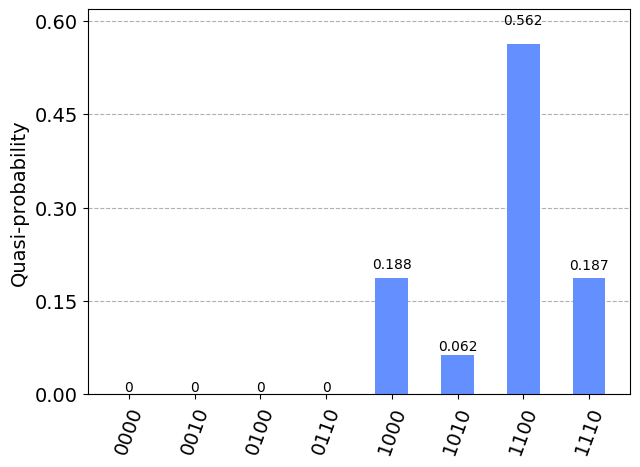

In [8]:
display(ql_StateVec.draw('latex'))

plot_distribution(ql_StateVec.probabilities_dict())

# circuit.measure(reversed(range(len(input_vector))), range(len(input_vector)))

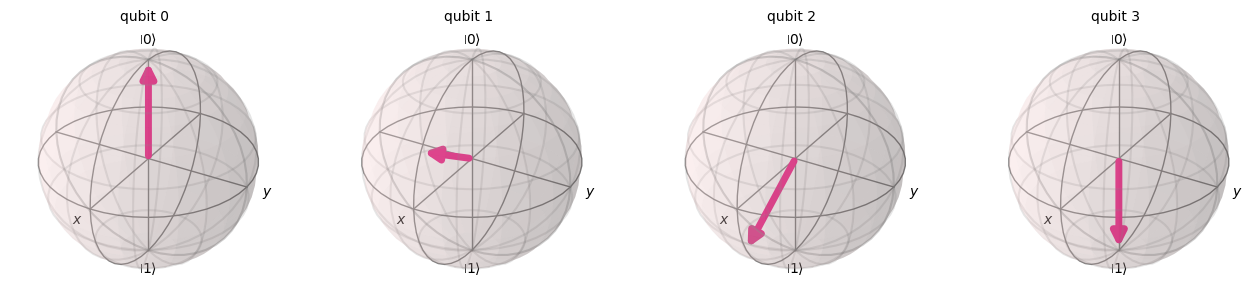

In [9]:
plot_bloch_multivector(ql_StateVec)

<IPython.core.display.Latex object>

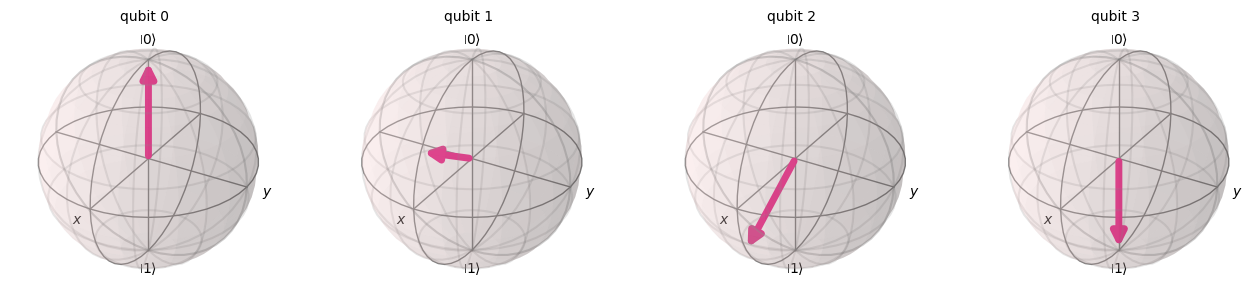

In [10]:
display(Statevector(circuit).draw('latex'))
plot_bloch_multivector(Statevector(circuit))

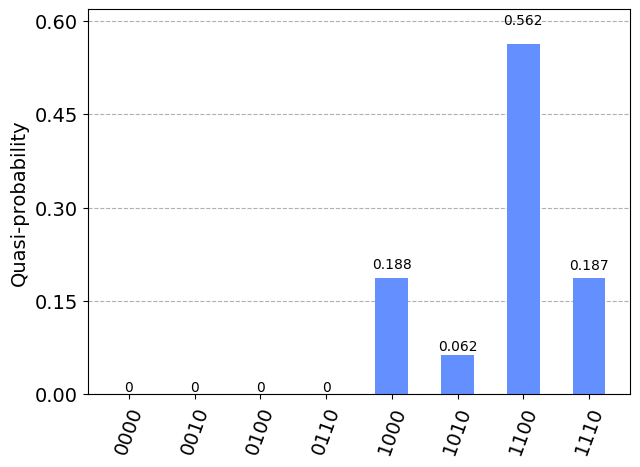

In [11]:
plot_distribution(Statevector(circuit).probabilities_dict())

Decoding is a complex process which is done classically after measurements. Initially, for each qubit, we will find the total count where that qubit has value '0'.

In [24]:
invertPixels(qc = circuit)
addMeasurements(qc = circuit)

C:\Users\sudha\AppData\Local\Temp\ipykernel_21332\2332887936.py:6: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.14 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = aer_sim.run(qobj)


{'1100': 563707, '1010': 62206, '1000': 187433, '1110': 186654}


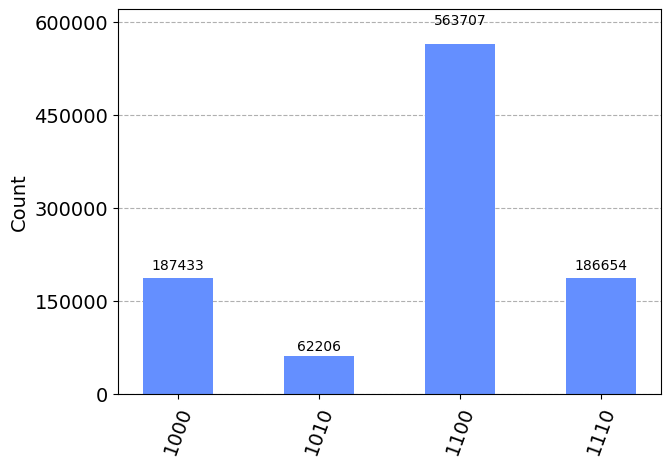

In [29]:
shots = 1000000
counts = simulate(qc = circuit, verbose=True)

In [26]:
# DECODE
output_values = np.zeros((len(input_vector)))

for item in counts:    
    for i, bit in enumerate(item):
        if bit == '0':
            output_values[i] += counts[item]

print("q0, q1, q2, q3 : ", output_values)

q0, q1, q2, q3 :  [      0.  249955.  749128. 1000000.]


Steps for reconstruction:
1. Find the _value / shots_ ratio
2. Take the square root of this ratio
3. Calculate _arccos_ and double the value

$$
output = 2 \times \arccos{(\sqrt{\frac{value}{shots}})}
$$
This ratio $value/shots$ is essentially the the conditional probability of observing a state given that the qubit associated selected pixel is in state $|0\rangle$.

4. Interpolate back from (0, $\pi$) to (0, 255)


In [27]:
# RECONSTRUCT
for i, value in enumerate(output_values):
    print(f"\nFor pixel {i}:")
    print(f"\tvalue/shots = {value}/{shots} = {value/shots}")
    print(f"\tsqrt(value/shots) = {(value/shots)**(1/2)}")
    print(f"\tarccos = {np.arccos((value/shots)**(1/2))}")
    print(f"\t2 * arccos = {2*np.arccos((value/shots)**(1/2))}")

# step 1,2,3
reconstruct = [2*np.arccos((value/shots)**(1/2)) for value in output_values]

# step 4
reconstruct = np.interp(reconstruct, (0, np.pi), (0, 255)).astype(int)

print(f"\nOriginal values: {input_vector}\nReconstructed Inverted values: {reconstruct}")


For pixel 0:
	value/shots = 0.0/1000000 = 0.0
	sqrt(value/shots) = 0.0
	arccos = 1.5707963267948966
	2 * arccos = 3.141592653589793

For pixel 1:
	value/shots = 249955.0/1000000 = 0.249955
	sqrt(value/shots) = 0.49995499797481774
	arccos = 1.0472495142798577
	2 * arccos = 2.0944990285597154

For pixel 2:
	value/shots = 749128.0/1000000 = 0.749128
	sqrt(value/shots) = 0.8655218079286044
	arccos = 0.5246050904822466
	2 * arccos = 1.0492101809644931

For pixel 3:
	value/shots = 1000000.0/1000000 = 1.0
	sqrt(value/shots) = 1.0
	arccos = 0.0
	2 * arccos = 0.0

Original values: [  0  85 170 255]
Reconstructed Inverted values: [255 170  85   0]


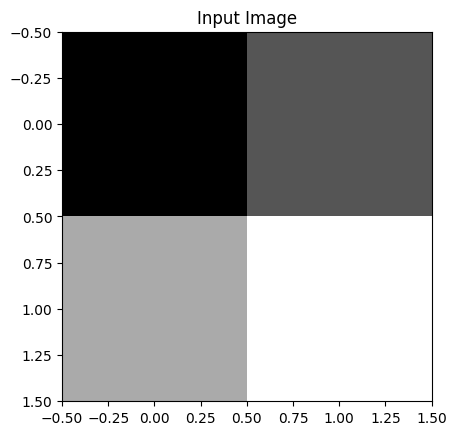

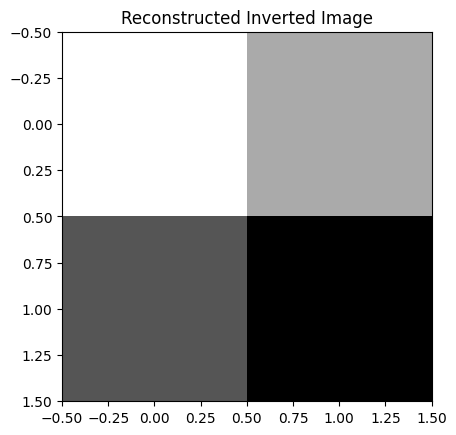

In [28]:
def plot_to_compare(input_vector, reconstruct):
    plt.imshow(np.reshape(input_vector, (2, 2)), cmap = 'gray')
    plt.title('Input Image')
    plt.show()
    plt.imshow(np.reshape(reconstruct, (2, 2)), cmap = 'gray')
    plt.title('Reconstructed Inverted Image')
    plt.show()

plot_to_compare(input_vector, reconstruct)

The Qubit Lattice model served as a base model for quantum encoding for image processing. Several other models like SQR and FRQI are based on this model.